# Correccion de armonicos tiempo real

In [3]:
from vds1022 import * 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Instancio al osciloscopio
dev = VDS1022()

##dev.dispose() # desconectarse
# Configuro el Osciloscopio para medir la corriente del sensor
fs = 80e3
dev.set_sampling(fs)  # maximo 40k a la entrada poner un filtro pasa bajos en 30k
dev.set_channel(CH1, range='10v', probe='10x',coupling=AC)
dev.set_trigger(CH1, EDGE, RISE, level='2.5v') ## Por el momento uso trigger para que al agregar la señal correctora este en fase. Luego hay que hacer esta sincronizacion a mano con el cruce por cero


# defino la ventana de tiempo
#dev.set_timerange('60ms') # Nota la cantidad de muestras que levanta siempre son 5k. Si cambio el timerange me cambia la fs


Lost connection to device.


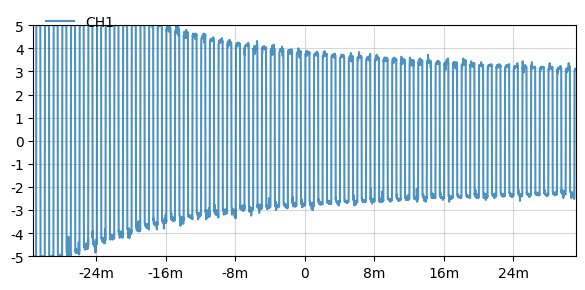

In [5]:
# Levanto medicion a ver como esta configurado
frames = dev.fetch() 
# Extraigo una muestra 
# Como no tengo configurado el trigger me da una muestra a partir del momento en el que la pido
frames.plot(backend="matplotlib")

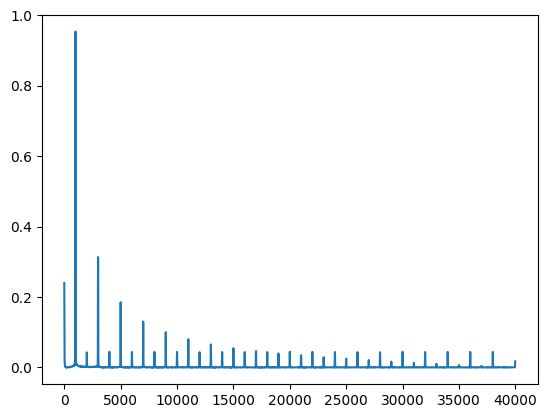

In [6]:
# Obtengo la FFT de la señal como muestra para ver el contenido armonico

values_i = frames.y()[0] # Valores channel 1
time_i = frames.x()

# Ventana para evitar leakege
window_hamm = np.hamming(len(values_i))
values = values_i * window_hamm

# Calcular la FFT de la señal     
fft_signal = np.fft.fft(values)

# Calcular las frecuencias correspondientes a las muestras de la FFT
frequencies = np.fft.fftfreq(len(fft_signal), 1/fs)

# normalizo la señal
fft_signal = fft_signal/ len(fft_signal)

#Elimino la mitad del esprectro asi como su continua
fft_signal = fft_signal[0:int(len(fft_signal)/2)]
fft_signal = np.abs(fft_signal)
frequencies = frequencies[0:len(fft_signal)]
#plt.plot(time,values)
plt.plot(frequencies,fft_signal)


In [7]:
def get_fundamental(fc_esperada,freq,values):
    resolucion = freq[1]-freq[0]
    indice = fc_esperada / resolucion
    slice_amp = values[int(indice * 0.35):int(indice * 1.65)]
    slice_freq = freq[int(indice * 0.35):int(indice * 1.65)]
    indice =  np.argmax(slice_amp)
    fundamental_value = slice_amp[indice]
    fundamental_freq = slice_freq[indice]
    return fundamental_freq,fundamental_value

In [8]:
## Detecto la fundamental
# Luego de la continua la fundamental debe ser la primer armonica de la señal. 

# elimino la continua
fft_signal = fft_signal[1:]
frequencies = frequencies[1:]
## Para tomar la fundamental puesto que puede darse el caso de que las armonicas sean mayores a la propia fundamental, se setea un valor de frecuencia esperado y luego se busca el valor con mayor amplitud mas cercano

fc_esperada = 1.2e3

fundamental_freq,fundamental_amp = get_fundamental(fc_esperada,frequencies,fft_signal)
print(fundamental_freq,fundamental_amp)


1008.0 0.9537213903046639


In [9]:
# Obtengo la señal deseasa (fundamental sin armonicos)
#muestras = 5000
#t = np.linspace(0,muestras/fs,int(fs))
fundamental =  fundamental_amp*np.sin(time_i*fundamental_freq*2*np.pi)


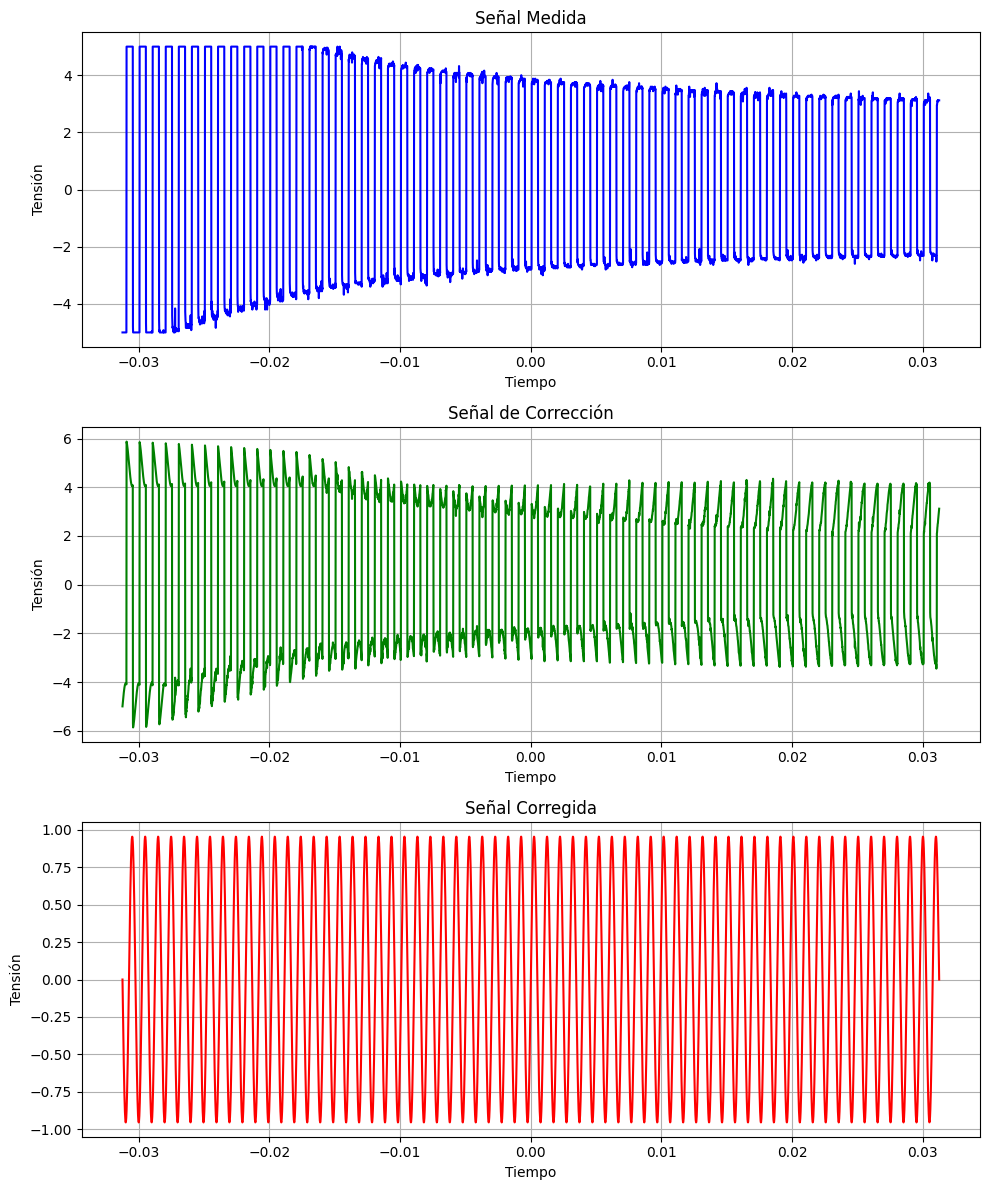

In [10]:
# Obtengo señal a inyectar, señal corregida y ploteo todo

correccion = values_i - fundamental ## Puedo hacer esto por que "values_i" es la señal medida con trigger, por lo que puedo ponerme en fase.

corregida = values_i - correccion

# Crear la figura y los ejes
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Graficar Señal Medida
axs[0].plot(time_i, values_i, label='Señal Medida', color='b')
axs[0].set_title('Señal Medida')
axs[0].set_xlabel('Tiempo')
axs[0].set_ylabel('Tensión')
axs[0].grid(True)

# Graficar Señal de Corrección
axs[1].plot(time_i, correccion, label='Señal de Corrección', color='g')
axs[1].set_title('Señal de Corrección')
axs[1].set_xlabel('Tiempo')
axs[1].set_ylabel('Tensión')
axs[1].grid(True)

# Graficar Señal Corregida
axs[2].plot(time_i, corregida, label='Señal Corregida', color='r')
axs[2].set_title('Señal Corregida')
axs[2].set_xlabel('Tiempo')
axs[2].set_ylabel('Tensión')
axs[2].grid(True)

# Ajustar el layout
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Procesamiento en tiempo real
A continuacion se hace la rutina que procesa en tiempo real la señal actual


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import threading
import time
from vds1022 import * 
from functions_AHF import *

In [12]:

# Instancio al osciloscopio
dev = VDS1022()
fs = 80e3

dev.set_channel(CH1, range='10v', probe='10x',coupling=AC)
dev.set_trigger(CH1, EDGE, RISE, level='2.5v') 
#Por el momento uso trigger para que al agregar la señal correctora este en fase. 
#Luego hay que hacer esta sincronizacion a mano con el cruce por cero


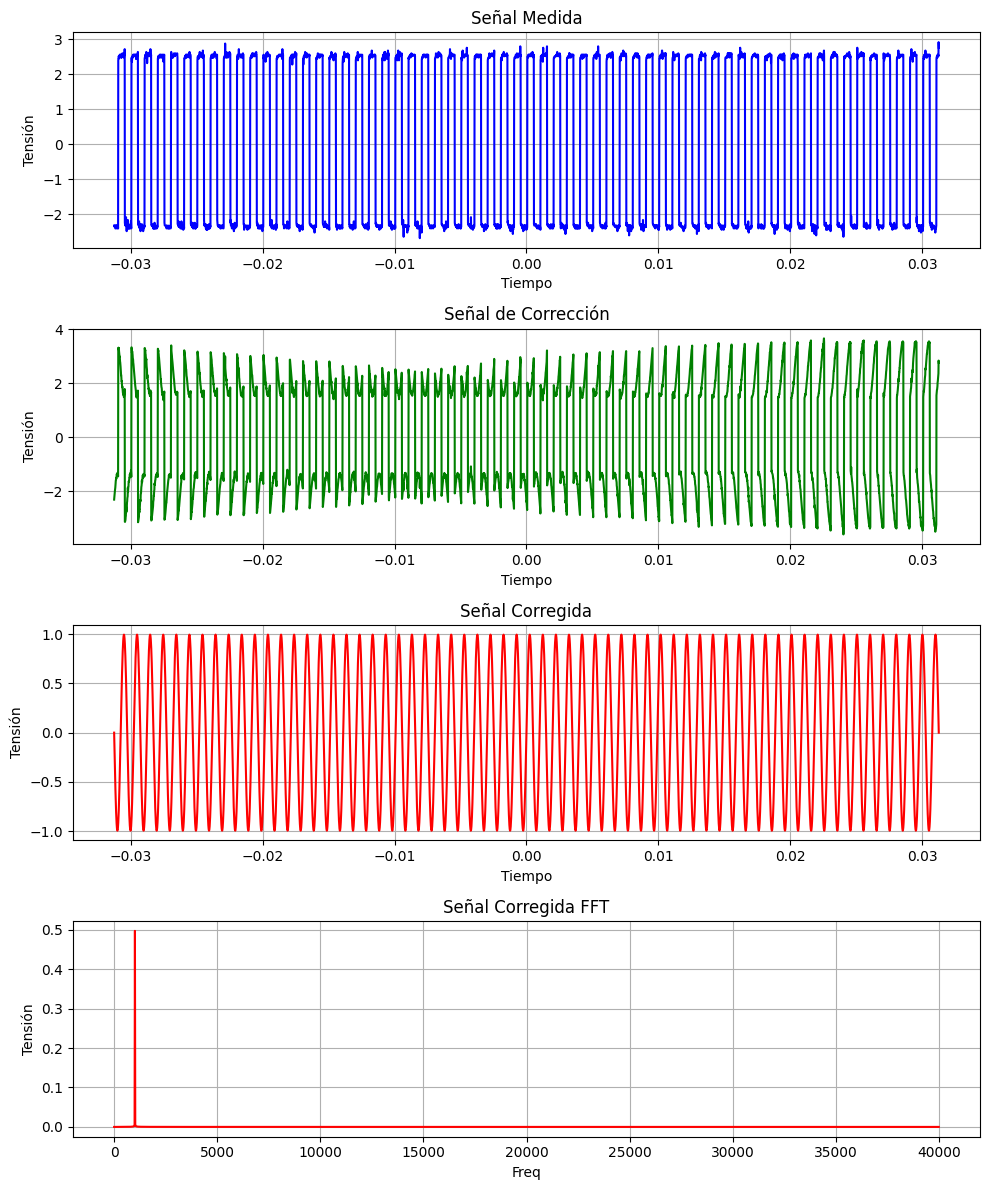

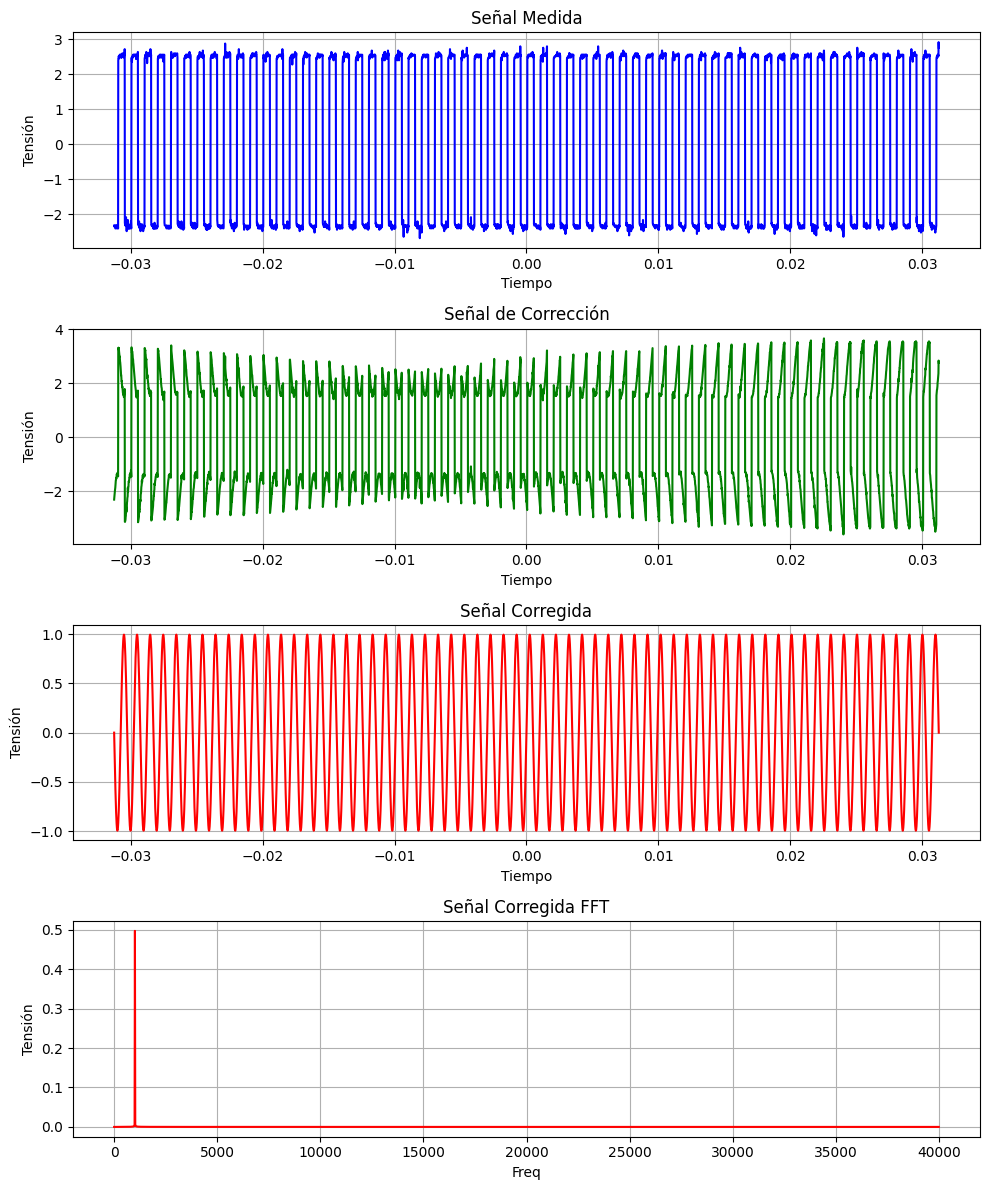

In [13]:

# Función para actualizar el gráfico
def update_plot():
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))
    fig.subplots_adjust(hspace=0.5)
    
    while not stop_thread:

        # Tomo señal del osciloscopio, defino la frecuencia de samplig con fs. La señal que tomo es la corriente de linea
        # TODO: aplicar factor tension -> corriente a la señal (ejemplo si es un Rshunt dividir la señal por Rshunt)
        # TODO: Tomar la tension de linea (CH2) para conseguir los cruces por cero.
        time_signal, values_signal = get_signal(dev,fs)
        
        # Obtengo la fundamental a partir de la señal de corriente medida.
        # Considerar: la corriente debe ser inyectada en fase con la corriente. Si la inyecto en fase con la tension estoy corrigiendo
        # el desfasaje entre tension y corriente. REVISAR ESTO. (¿Tengo que inyectar en fase con tension o con corriente?)
        # TODO: conseguir fundamental a partir de filtrado
        fundamental = get_fundamental_FFT(values_signal,time_signal,fs,f_esperada = 1e3) # Ajustar f_esperada, para nuestro caso seria 50hz 
        
        # Calculo la señal de correccion e "Inyecto" en la linea la señal obtenida para corregir la señal resultante.
        # TODO: Para inyectarla en la linea hay que comprobar la fase a partir de los cruces por cero.
        # Considerar: al inyectar la corriente en la linea se deberia "corregir" la corriente que medimos. 
        # Si esto ocurre entonces una vez corregida, la medicion dara una corriente "en fase y sin armonicos", lo cual hara 
        # que la proxima correccion no considere lo que ya corrigio. Habria que ir "sumando" las correcciones que se hacen

        values_correccion, values_corregida = get_correccion(values_signal,fundamental)
        
        # Ploteo las señales que se obtienen para ver resultados
        # TODO: la señal corregida y la señal medida deberian ser las mismas puesto que ambas son lo que medimos
        # por lo que habria que unificarlas. En este caso como la medida no se esta corrigiendo entonces no vemos que sean iguales
        
        plot_signals(time_signal,values_signal,values_correccion,values_corregida,fs,axs,fig)

        time.sleep(1)


# Variable para detener el thread
stop_thread = False

# Crear y empezar el thread
thread = threading.Thread(target=update_plot)
thread.start()

# Simular la actualización de datos
try:
    while True: time.sleep(1)
except KeyboardInterrupt:
    stop_thread = True
    thread.join()



Ahora se agrega el sistema de control. La señal de linea se mide una vez y se le agrega una cierta variacion como ruido. Luego el sistema de control mide la señal obtenida y la usa para ajustar el resultado.

El esquema seria el siguiente

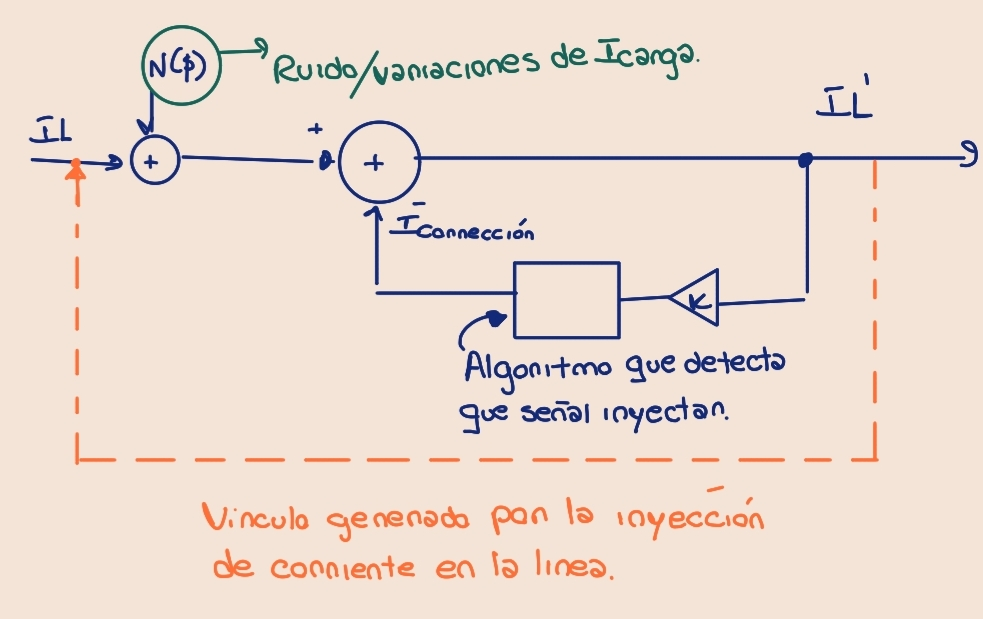



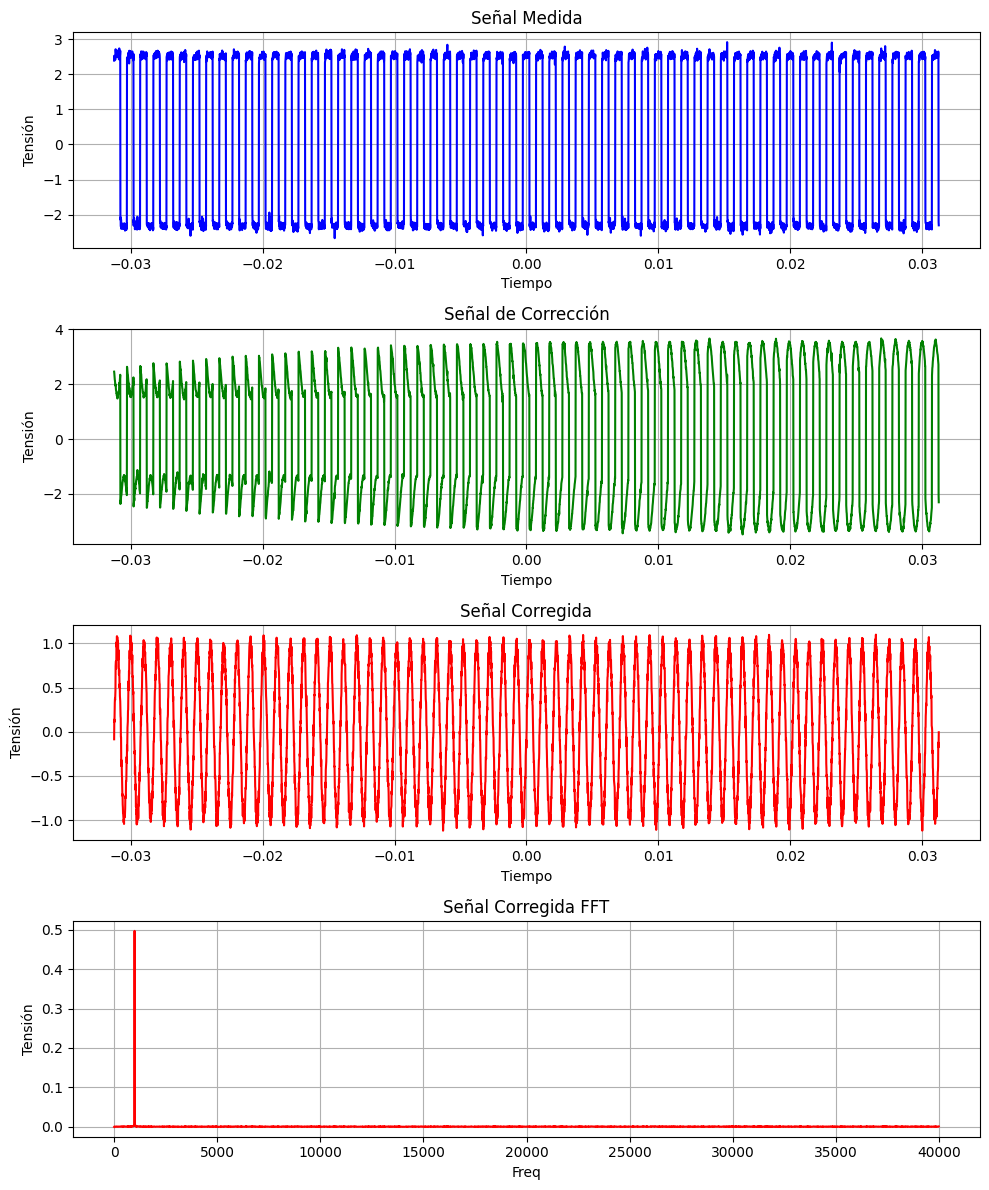

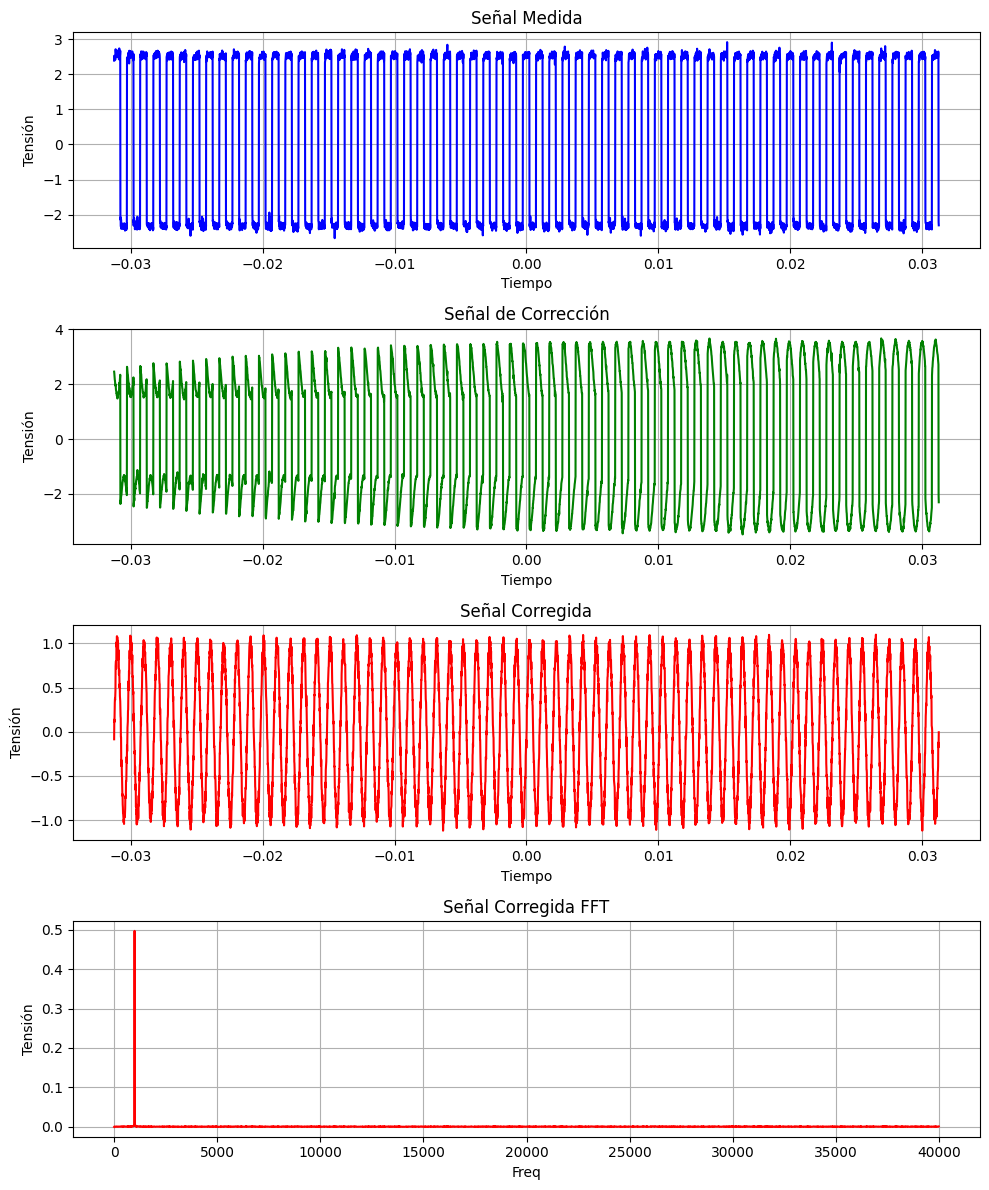

In [14]:
K = 0.2 # CTE proporcional

# Función para actualizar el gráfico
def update_plot():
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))
    fig.subplots_adjust(hspace=0.5)
    # Tomo señal del osciloscopio, defino la frecuencia de samplig con fs. La señal que tomo es la corriente de linea
    time_signal, values_signal = get_signal(dev,fs)

    I_correccion = np.zeros(len(values_signal))

    # Obtengo la fundamental a partir de la señal de corriente medida.
    # TODO: La fundamental se deberia calcular periodicamente para comprobar cambios en la corriente activa.
    
    fundamental = get_fundamental_FFT(values_signal,time_signal,fs,f_esperada = 1e3)*K # Ajustar f_esperada, para nuestro caso seria 50hz 
    
    while not stop_thread:
        
        # A la señal de entrada le agrego ruido (variaciones en la señal-)
        input_signal = values_signal + np.random.uniform(-0.1, 0.1, len(values_signal)) # Agrego ruido a la señal. 
        # NOTA: enrealidad lo que uno mide es la señal corrigiendose. De forma que Como no tengo forma de 

        # Señal de error 
        output_signal = input_signal - I_correccion

        # Señal de entrada al algoritmo de deteccion de armonicos.
        input_algoritmo = output_signal * K

        #NOTA: El factor K permite evitar que haya picos en la respuesta 


        # Algoritmo para obtener la señal de correccion.

        # Calculo la señal de correccion e "Inyecto" en la linea la señal obtenida para corregir la señal resultante.
        # TODO: Para inyectarla en la linea hay que comprobar la fase a partir de los cruces por cero.
        # Considerar: al inyectar la corriente en la linea se deberia "corregir" la corriente que medimos. 
        # Si esto ocurre entonces una vez corregida, la medicion dara una corriente "en fase y sin armonicos", lo cual hara 
        # que la proxima correccion no considere lo que ya corrigio. Habria que ir "sumando" las correcciones que se hacen

        values_correccion, _ = get_correccion(input_algoritmo,fundamental)
        
        I_correccion =  values_correccion + I_correccion
        
        # Ploteo las señales que se obtienen para ver resultados
        
        plot_signals(time_signal,input_signal,I_correccion,output_signal,fs,axs,fig)

        time.sleep(1)


# Variable para detener el thread
stop_thread = False

# Crear y empezar el thread
thread = threading.Thread(target=update_plot)
thread.start()

# Simular la actualización de datos
try:
    while True: time.sleep(1)
except KeyboardInterrupt:
    stop_thread = True
    thread.join()



# Medicion de THD y factor de potencia de la señal que se mide

Con esta parte del script podemos determinar el THD y factor de potencia que se obtiene con el osciloscopio. Para poder hacer la medicion en necesario medir con una punta la tension de linea y la corriente da la misma. Para el caso de la corriente es necesario poner el coeficiente de escala.


In [2]:
from vds1022 import * 
import numpy as np
import matplotlib.pyplot as plt
from functions_AHF import *
# Tomo osciloscopio ya instanciado
dev = VDS1022()

fs = 80e3
dev.set_sampling(fs)  # maximo 40k a la entrada poner un filtro pasa bajos en 30k

dev.set_channel(CH1, range='10v', probe='10x',coupling=AC)
# Si medimos la corriente con una Rshunt de 0.1ohm y la punta en X10, entonces la ganancia para coneseguir la corriente es -> 1  
dev.set_channel(CH2, range='10v', probe='1x',coupling=AC)

dev.set_trigger(CH1, EDGE, RISE, level='2.5v') 

frames = dev.fetch()

# Supongo en frame[0] la tension y frame[1] la corriente

print(f"El FP es de : { frames.power_factor() }")

values_i = frames[1].y()
print(f"La distorcion armonica de la corriente es : {calcular_thd(values_i,fs) }")


El FP es de : -0.023686882872764794


TypeError: calcular_thd() missing 1 required positional argument: 'fs'